In [0]:
from fastai.vision import *
import pandas as pd
from fastai.metrics import error_rate, accuracy
from fastai.callbacks import *

In [0]:
import fastai; fastai.__version__

Out[2]: '1.0.61'

In [0]:
import pandas; pandas.__version__

Out[3]: '1.0.0'

If you're using a computer with an unusually small GPU, you may get an out of memory error when running this notebook. If this happens, click Kernel->Restart, uncomment the 2nd line below to use a smaller batch size (you'll learn all about what this means during the course), and try again.

In [0]:
bs = 24  # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [0]:
year = '2017'

In [0]:
df1 = pd.read_csv('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/Intensity/cnn_ceni_col_' + year + '_test10_dane350.csv')
df1.head()

Out[6]:

name 
 bin_GMM 
 
 
 
 
 0 
 CNN_DIMG_COL_2017_ST_384_3840_13_041734.jpg 
 1 
 
 
 1 
 CNN_DIMG_COL_2017_ST_384_3840_13_037796.jpg 
 1 
 
 
 2 
 CNN_DIMG_COL_2017_ST_384_3840_13_038938.jpg 
 1 
 
 
 3 
 CNN_DIMG_COL_2017_ST_384_3840_13_040046.jpg 
 1 
 
 
 4 
 CNN_DIMG_COL_2017_ST_384_3840_13_029652.jpg 
 1

In [0]:
import cv2
from fastai.imports import *

In [0]:
from PIL import Image, ImageFile; 
ImageFile.LOAD_TRUNCATED_IMAGES = True;

In [0]:

from fastai.tabular import *
#from fastai.text.all import *
#from fastai.vision.all import *
from fastai import *
from fastai.vision import *

In [0]:
from fastai import *
from pathlib import Path
from fastai.vision import *
import os
root_col='/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/'
aug_tfms=[contrast(scale=(0.9, 1.11),p=0.9)
          , dihedral()
          , symmetric_warp(magnitude=(-0.2,0.2))
]
tfms = get_transforms(flip_vert=True, max_lighting=0.1
                    ,xtra_tfms=aug_tfms
                    )
data = ImageDataBunch.from_csv(
  path=root_col,
  folder= year +'/JPG',
  csv_labels='Intensity/cnn_ceni_col_' + year + '_trn90_dane350.csv',
  valid_pct=0.2,
  fn_col=0,
  label_col=1,
  ds_tfms=tfms,
  size=384 ).normalize(imagenet_stats)

The first thing we do when we approach a problem is to take a look at the data. We always need to understand very well what the problem is and what the data looks like before we can figure out how to solve it. Taking a look at the data means understanding how the data directories are structured, what the labels are and what some sample images look like.

In [0]:
path_img = '/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/' +year +'/JPG'
fnames = get_image_files(path_img)
fnames[:5]

Out[11]: [PosixPath('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_000001.jpg'),
 PosixPath('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_000002.jpg'),
 PosixPath('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_000003.jpg'),
 PosixPath('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_000004.jpg'),
 PosixPath('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_000005.jpg')]

# Training

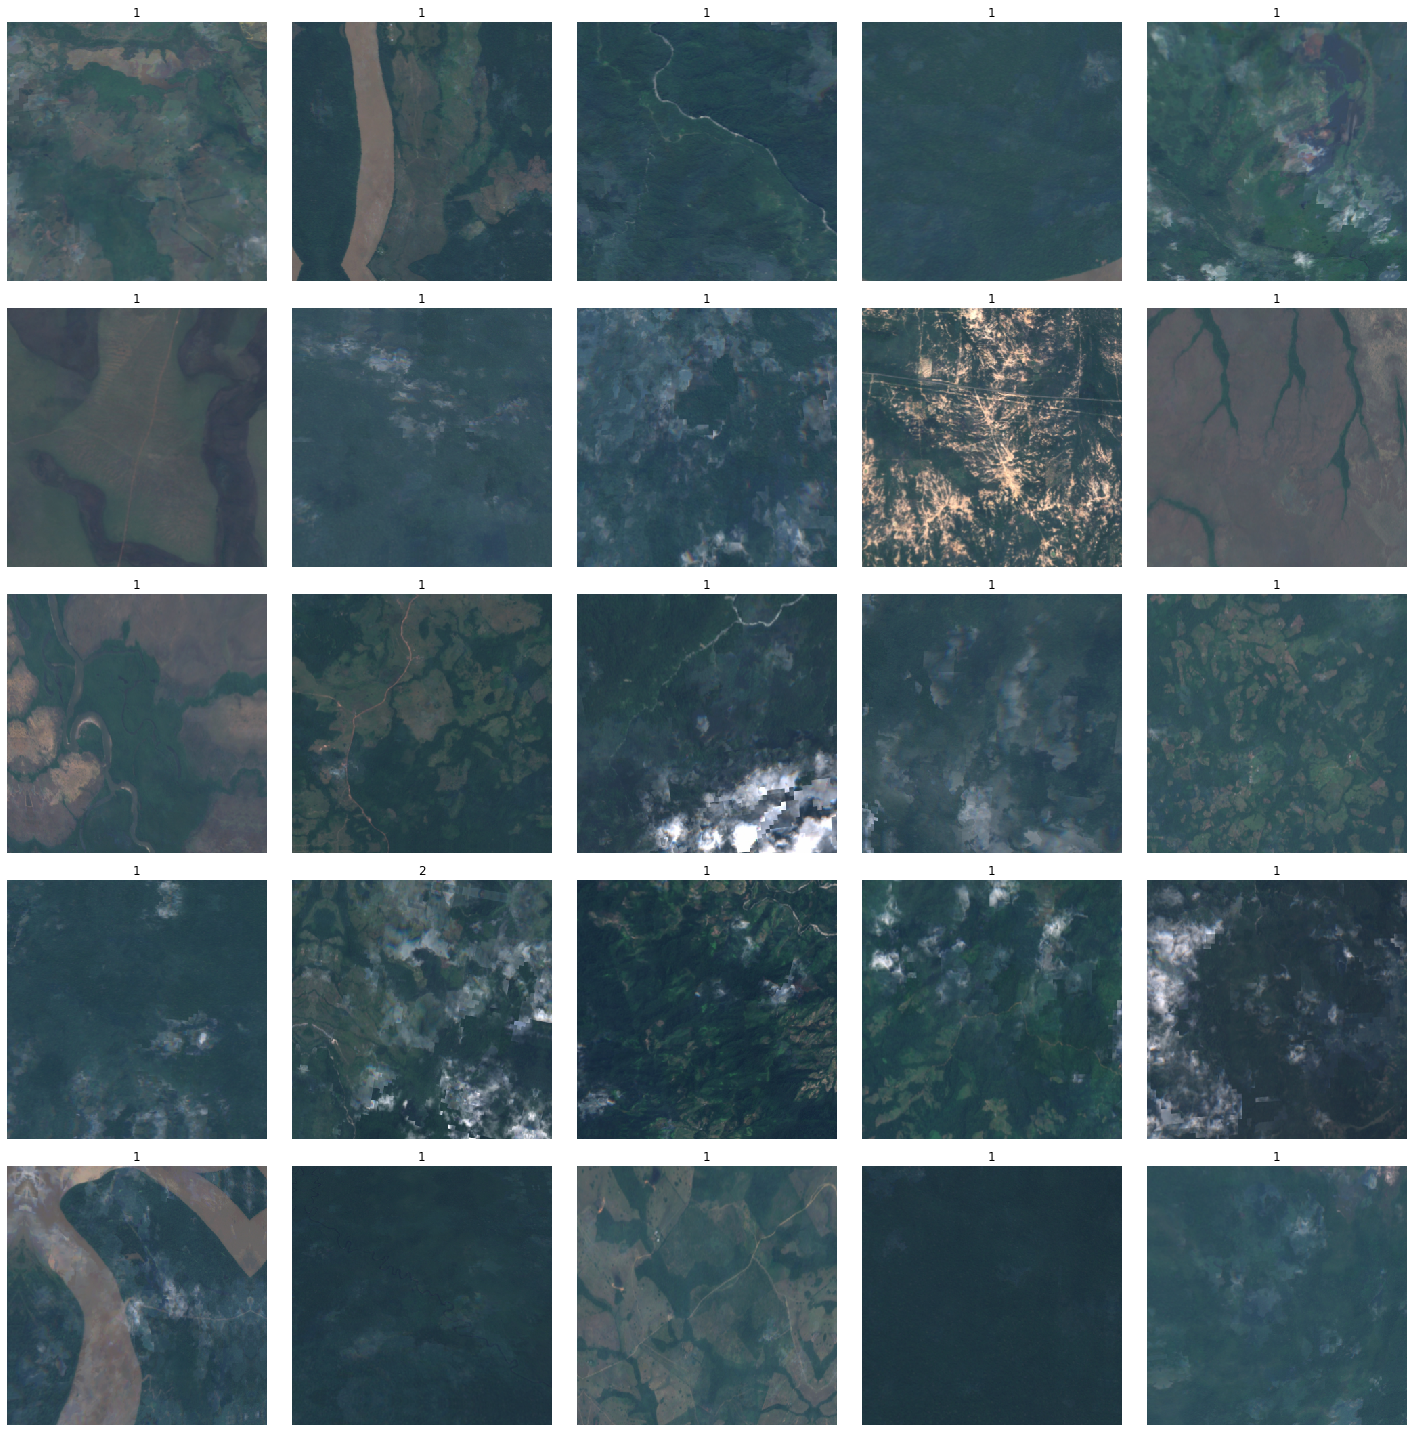

In [0]:
data.show_batch(nrows=5, figsize=(20,20))

In [0]:
# See the number of images in each data set
print(len(data.train_ds), len(data.valid_ds))

56144 14035

Training: resnet34

In [0]:
import torch
import torch.nn as nn

In [0]:

weights = torch.cuda.FloatTensor([0.4, 1.0, 1.3])
learn = cnn_learner(data, models.resnet34, metrics = [error_rate], loss_func=torch.nn.CrossEntropyLoss(weight = weights)
                   )

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
 0%| | 0.00/83.3M [00:00<?, ?B/s] 21%|██ | 17.2M/83.3M [00:00<00:00, 180MB/s] 47%|████▋ | 38.8M/83.3M [00:00<00:00, 192MB/s] 72%|███████▏ | 60.2M/83.3M [00:00<00:00, 201MB/s] 97%|█████████▋| 80.8M/83.3M [00:00<00:00, 205MB/s]100%|██████████| 83.3M/83.3M [00:00<00:00, 212MB/s]

In [0]:
#from fastai.callbacks import SaveModelCallback
from fastai.callbacks import *

In [0]:

callbacks = [
  SaveModelCallback(learn, monitor='error_rate', mode='min', name='COL_' + year + '_ST_VI_384_3840_13_ALL_trn90'),
  ShowGraph(learn),
  EarlyStoppingCallback(learn, min_delta=0.0001, patience=3)
]

learn.callbacks = callbacks

In [0]:
#Build the CNN model with the pretrained resnet34
learn.fit_one_cycle(8, wd = 0.1) 

█epoch train_loss valid_loss error_rate time 
██0 0.497799 0.432083 0.105308 19:19 
Better model found at epoch 0 with error_rate value: 0.1053081601858139.
██1 0.463935 0.406767 0.104596 19:16 
Better model found at epoch 1 with error_rate value: 0.10459565371274948.
██2 0.424277 0.387578 0.083648 19:15 
Better model found at epoch 2 with error_rate value: 0.08364802598953247.
██3 0.417051 0.379914 0.076452 19:13 
Better model found at epoch 3 with error_rate value: 0.07645172625780106.
██4 0.401680 0.363233 0.078019 19:13 
██5 0.396568 0.360263 0.081511 19:14 
██6 0.382046 0.356624 0.078945 19:15 
██7 0.388310 0.357595 0.076665 19:13

unfreeze only last 2 layers, check optimal learning rate and continue with training of CNN

█epoch train_loss valid_loss error_rate time 
█0 1.251294 #na# 02:00 
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 4.37E-06
/databricks/python/lib/python3.7/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
 warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")

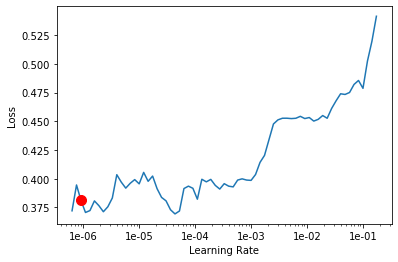

In [0]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(2,max_lr=slice(4.37E-06, 9.12E-07),wd=0.1)


█epoch train_loss valid_loss error_rate time 
██0 0.402394 0.369272 0.078874 21:56 
Better model found at epoch 0 with error_rate value: 0.07887424528598785.
██1 0.393970 0.365691 0.081511 21:58

█epoch train_loss valid_loss error_rate time 
█0 1.317016 #na# 02:31 
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 3.31E-07
/databricks/python/lib/python3.7/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
 warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")

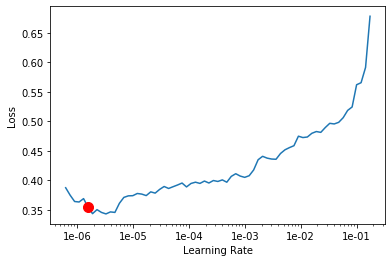

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)


In [0]:
learn.unfreeze()
learn.fit_one_cycle(1,max_lr=slice(3.31E-07, 3.31E-07 + 3.31E-07),wd=0.1)

█epoch train_loss valid_loss error_rate time 
██0 0.379290 0.371521 0.076808 27:04 
Better model found at epoch 0 with error_rate value: 0.07680798321962357.

Results

Let's see what results we have got.

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. 

Furthermore, we plot the confusion matrix. Model finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

█Out[23]: True

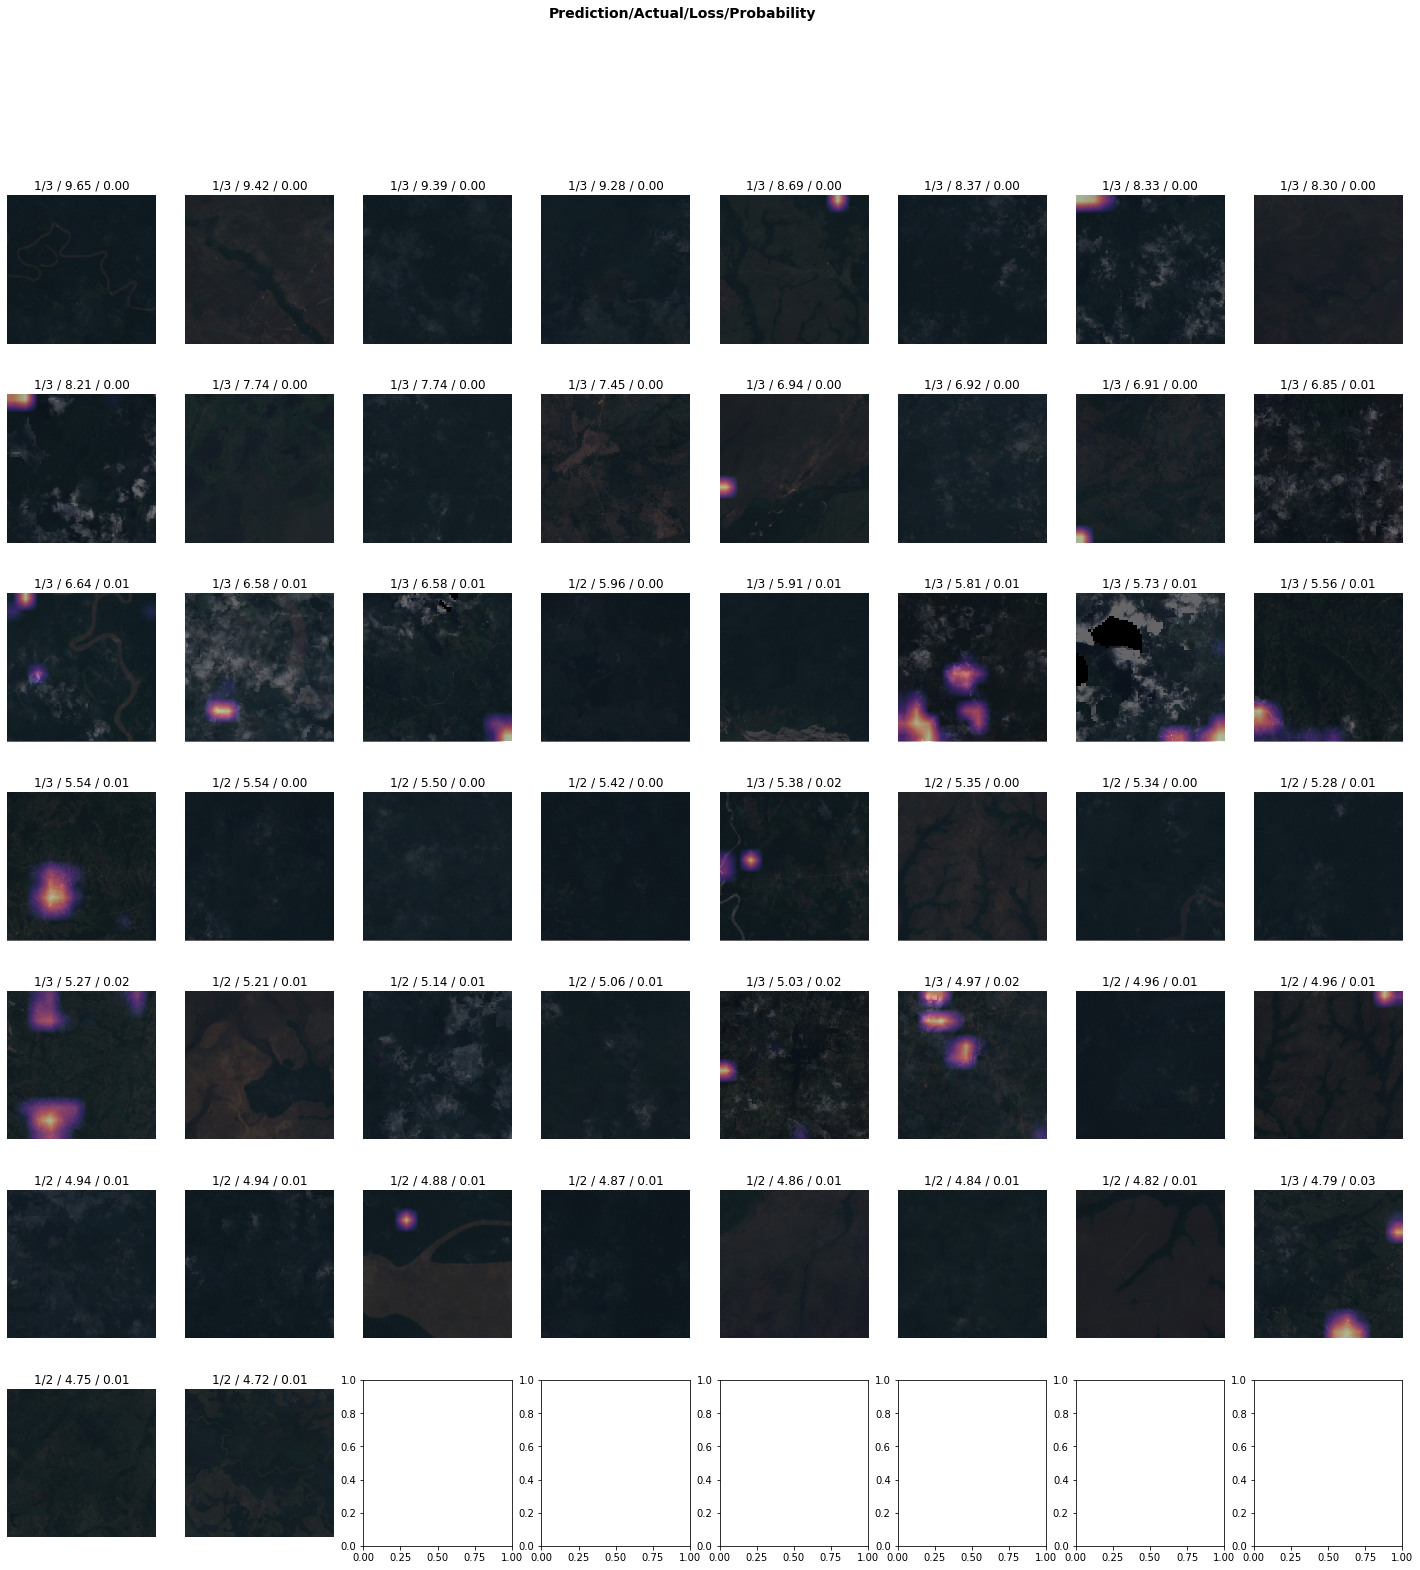

In [0]:
interp.plot_top_losses(50, figsize=(25,25), heatmap=True)


In [0]:
##to display filenames##
losses,idxs = interp.top_losses(50)
for p in data.valid_ds.x.items[idxs]:
    print(p)

/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_061934.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_057032.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_059474.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_059705.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_061498.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_063996.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_057054.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_058180.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_059238.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_060153.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_057613.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_059925.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_057895.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_056248.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_059548.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_045635.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_058470.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_059475.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_062229.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_061279.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_015936.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_057310.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_035711.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_060384.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_063538.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_057104.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_060241.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_061555.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_012877.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_060376.jpg
/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017/JPG/CNN_DIMG_COL_2017_ST_384_3840_13_056742.jpg
/dbfs/mnt/pobreza/changeanalysis

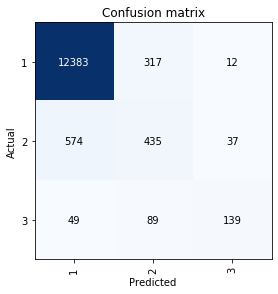

In [0]:
interp.plot_confusion_matrix()

In [0]:
learn.save('Ex1_COL_' + year + '_ST_VI_384_3840_13_ALL_trn90_final')
learn.export(file='/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/models/Ex1_lrn_COL_'+ year+'_ST_VI_384_3840_13_ALL_trn90_final.pkl') #train and export learner


Inference

In [0]:
#memory garbage collection: take object that stores a lot of mem -> avoid restarting notebook:
learn=None
gc.collect()

Out[28]: 106331

LabelLists;

Train: LabelList (7710 items)
x: ImageList
Image (3, 386, 384),Image (3, 386, 384),Image (3, 386, 384),Image (3, 386, 384),Image (3, 386, 383)
y: CategoryList
1,1,1,1,1
Path: /dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017;

Valid: LabelList (7710 items)
x: ImageList
Image (3, 386, 384),Image (3, 386, 384),Image (3, 386, 384),Image (3, 386, 384),Image (3, 386, 383)
y: CategoryList
1,1,1,1,1
Path: /dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/2017;

Test: None
█

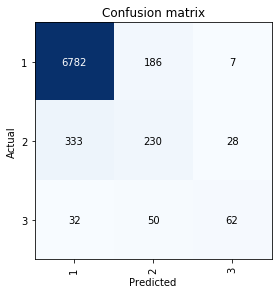

In [0]:
#may require to free up space on GPU before running below

import pandas as pd
  # Create Databunch
df = pd.read_csv("/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/Intensity/cnn_ceni_col_" + year + "_test10_dane350.csv")
df_val = df[['bin_GMM','name']]


il = ImageList.from_df(df=df_val,path='/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/' + year + '/',cols='name',folder='JPG',suffix='')
ils = il.split_none() #All data on Train Set
ll = ils.label_from_df(0) 
ll.valid = ll.train # Trick!
print(ll)

ll.transform(tfms=None,size=384) # Optional Transforms 
data = ll.databunch(bs=64);
data.normalize(imagenet_stats) 

learn = cnn_learner(data, models.resnet34, metrics = error_rate)
learn = load_learner('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/models/', file='Ex1_lrn_COL_' + year + '_ST_VI_384_3840_13_ALL_trn90_final.pkl')
learn.load('/dbfs/mnt/pobreza/changeanalysis/func-mintic-pobrezamultidimensio/IMAGENES/models/Ex1_COL_' + year + '_ST_VI_384_3840_13_ALL_trn90_final')
learn.data.valid_dl = data.valid_dl #override with inference data with transfroms and other..
learn.loss_func = torch.nn.CrossEntropyLoss()
learn.metrics
 
interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)
interp.plot_confusion_matrix()

In [0]:
tfms = None
data_test = data
# This is the function definition:

def evaluate_model_from_interp(interp, data):
    # perform a "manual" evaluation of the model to take a look at predictions vs. labels and to
    # re-compute accuracy from scratch (to double check and also because I didn't find a quick way
    # to extract accuracy inside the guts of Fast.ai after a call to validate() on the test set...)
    print(f'Interp has {len(interp.y_true)} ground truth labels: {interp.y_true}')
    print(f'Interp yielded {len(interp.preds)} raw predictions. First two raw predictions are: {interp.preds[:2]}')
    print(f'The problem had {len(data.classes)} classes: {data.classes}') # data.c is just len(data.classes)
    print('')
    print(f'Pred -> GroundTruth = PredLabel -> GroundTruthLabel')

    ok_pred = 0

    for idx, raw_p in enumerate(interp.preds):
        pred = np.argmax(raw_p)
        if idx < 10:
            print(f'{pred} -> {interp.y_true[idx]} = {data.classes[pred]} -> {data.valid_ds.y[idx]}')
        if pred == interp.y_true[idx]:
            ok_pred += 1

    acc = ok_pred / len(interp.y_true)
    print(f'Overall accuracy of the model: {acc:0.5f}')
#And then it can be called simply with:

evaluate_model_from_interp(interp, data_test)

Interp has 7710 ground truth labels: tensor([0, 0, 0, ..., 0, 0, 1])
Interp yielded 7710 raw predictions. First two raw predictions are: tensor([[0.9616, 0.0360, 0.0024],
 [0.9627, 0.0348, 0.0026]])
The problem had 3 classes: [1, 2, 3]

Pred -> GroundTruth = PredLabel -> GroundTruthLabel
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
0 -> 0 = 1 -> 1
Overall accuracy of the model: 0.91751